
Labeled Data with Binary Events:
      id Home_Masked Away_Masked  Excitement_Score Excitement_Label
0  93323      Team_3     Team_19                 3         Exciting
1  93336     Team_13     Team_15                 1           Normal
2  93343      Team_4      Team_8                 1           Normal
3  93344      Team_5     Team_19                 1           Normal
4  93347      Team_9     Team_20                 1           Normal


/var/folders/c_/rs13jmts3nbf9xfm917mh9p80000gn/T/ipykernel_11179/3513674916.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Excitement_Label", palette="viridis")


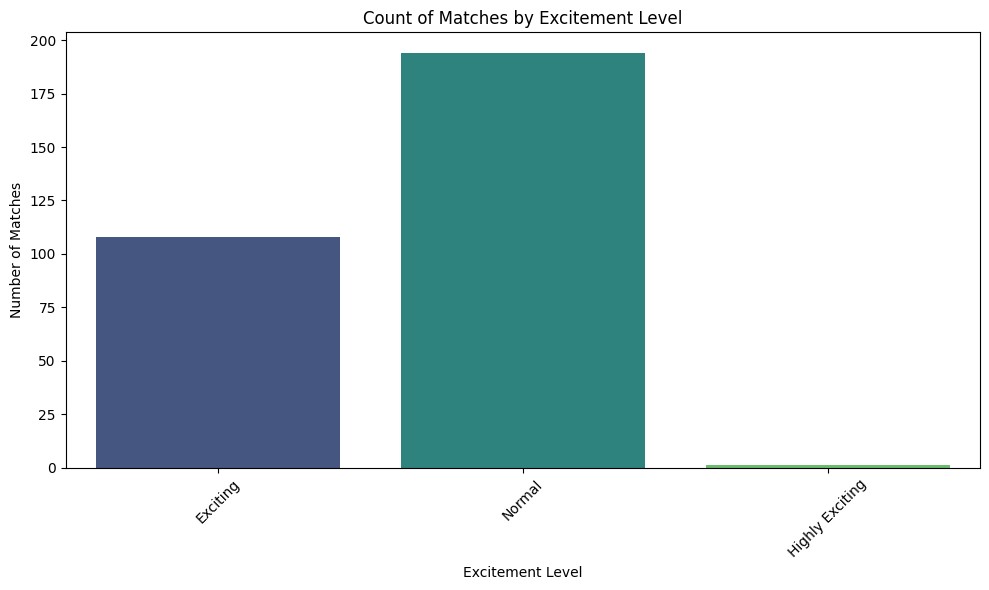


Enhanced processed data with binary events saved to enhanced_processed_data_with_binary_events.tsv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

# Load the data
df = pd.read_csv("23_24_match_details.csv", sep=",")

# Define comprehensive team name variations
team_variations = {
    "Team_1": ["Arsenal"],
    "Team_2": ["Aston Villa"],
    "Team_3": ["Bournemouth"],
    "Team_4": ["Brentford"],
    "Team_5": ["Brighton & Hove Albion", "Brighton"],
    "Team_6": ["Burnley"],
    "Team_7": ["Chelsea"],
    "Team_8": ["Crystal Palace"],
    "Team_9": ["Everton"],
    "Team_10": ["Fulham"],
    "Team_11": ["Liverpool"],
    "Team_12": ["Luton Town"],
    "Team_13": ["Manchester City", "Man City"],
    "Team_14": ["Manchester United"],
    "Team_15": ["Newcastle United", "Newcastle"],
    "Team_16": ["Nottingham Forest"],
    "Team_17": ["Sheffield United"],
    "Team_18": ["Tottenham Hotspur", "Tottenham"],
    "Team_19": ["West Ham United", "West Ham"],
    "Team_20": ["Wolves"],
}

# Create a reverse mapping dictionary with lowercase keys for case-insensitive matching
mask_mapping = {}
for team_label, variations in team_variations.items():
    for name in variations:
        mask_mapping[name.lower()] = team_label

# Function to replace team names in text with their masked counterparts
def mask_teams(text, mapping):
    if pd.isnull(text):
        return text
    sorted_teams = sorted(mapping.keys(), key=len, reverse=True)
    for team in sorted_teams:
        pattern = r"\b" + re.escape(team) + r"(?:'s)?\b"
        replacement = mapping[team]
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Apply masking to 'Home' and 'Away' columns
if "Home" in df.columns:
    df["Home_Masked"] = df["Home"].str.lower().map(mask_mapping)
else:
    df["Home_Masked"] = np.nan

if "Away" in df.columns:
    df["Away_Masked"] = df["Away"].str.lower().map(mask_mapping)
else:
    df["Away_Masked"] = np.nan

# Apply masking to 'events' and 'summary' columns
if "events" in df.columns:
    df["text_Masked"] = df["events"].apply(lambda x: mask_teams(x, mask_mapping))
else:
    df["text_Masked"] = np.nan

# Define binary event functions
def red_card_followed_by_goal(text):
    """Check if there was a red card followed by a goal."""
    if pd.isnull(text): return 0
    # Pattern to capture red card followed by a goal
    if re.search(r"red card.*?goal", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def last_minute_goal(text):
    """Check if a goal was scored in the last minute or extra time."""
    if pd.isnull(text): return 0
    if re.search(r"goal.*?(90'|extra time)", text, re.IGNORECASE):
        return 1
    return 0

def comeback_attempt(text):
    """Check if there was an attempt to come back (team scores after being down)."""
    if pd.isnull(text): return 0
    if re.search(r"down.*?goal", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def var_review_red_card(text):
    """Check if a VAR review led to a red card."""
    if pd.isnull(text): return 0
    if re.search(r"VAR review.*?red card", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def hat_trick(text):
    """Check if there was a hat-trick."""
    if pd.isnull(text): return 0
    if re.search(r"hat[- ]trick", text, re.IGNORECASE):
        return 1
    return 0

def penalty_drama(text):
    """Check if there was a missed or contested penalty."""
    if pd.isnull(text): return 0
    if re.search(r"penalty.*?(missed|saved|contested)", text, re.IGNORECASE):
        return 1
    return 0

# Apply the binary event functions
if "text_Masked" in df.columns:
    df["Red_Card_Followed_By_Goal"] = df["text_Masked"].apply(red_card_followed_by_goal)
    df["Last_Minute_Goal"] = df["text_Masked"].apply(last_minute_goal)
    df["Comeback_Attempt"] = df["text_Masked"].apply(comeback_attempt)
    df["VAR_Review_Red_Card"] = df["text_Masked"].apply(var_review_red_card)
    df["Hat_Trick"] = df["text_Masked"].apply(hat_trick)
    df["Penalty_Drama"] = df["text_Masked"].apply(penalty_drama)
else:
    df["Red_Card_Followed_By_Goal"] = 0
    df["Last_Minute_Goal"] = 0
    df["Comeback_Attempt"] = 0
    df["VAR_Review_Red_Card"] = 0
    df["Hat_Trick"] = 0
    df["Penalty_Drama"] = 0

# Calculate overall excitement score by summing the binary event columns
df["Excitement_Score"] = (
    df["Red_Card_Followed_By_Goal"] +
    df["Last_Minute_Goal"] +
    df["Comeback_Attempt"] +
    df["VAR_Review_Red_Card"] +
    df["Hat_Trick"] +
    df["Penalty_Drama"]
)

# Label excitement level based on score threshold
def label_excitement(score):
    if score >= 2:
        return "Exciting"
    else:
        return "Normal"

df["Excitement_Label"] = df["Excitement_Score"].apply(label_excitement)

# Display summary of the labeled data
print("\nLabeled Data with Binary Events:")
print(df[["id", "Home_Masked", "Away_Masked", "Excitement_Score", "Excitement_Label"]].head())

# Plot distribution of excitement labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Excitement_Label", palette="viridis")
plt.title("Count of Matches by Excitement Level")
plt.xlabel("Excitement Level")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save enhanced dataset
save_path = "enhanced_processed_data_with_binary_events.tsv"
df.to_csv(save_path, sep="\t", index=False)
print(f"\nEnhanced processed data with binary events saved to {save_path}")

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temp (20%)
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Excitement_Label"])

# Split the temp data into validation (10%) and test (10%)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data["Excitement_Label"])

# Check the distribution of labels in each split
print("\nDistribution of Excitement Levels:")
print("Training Set:")
print(train_data["Excitement_Label"].value_counts(normalize=True))
print("\nValidation Set:")
print(validation_data["Excitement_Label"].value_counts(normalize=True))
print("\nTest Set:")
print(test_data["Excitement_Label"].value_counts(normalize=True))

# Save each split to separate files
train_data.to_csv("train_data.tsv", sep="\t", index=False)
validation_data.to_csv("validation_data.tsv", sep="\t", index=False)
test_data.to_csv("test_data.tsv", sep="\t", index=False)

print("\nData has been split and saved into the following files:")
print("1. Training Data: train_data.tsv")
print("2. Validation Data: validation_data.tsv")
print("3. Test Data: test_data.tsv")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.